In [23]:
import sys
sys.path.append("../../../")

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from riemannian_geometry.computations.sample import sample_layers
from riemannian_geometry.computations.riemann_metric import LocalDiagPCA_Riemann
from riemannian_geometry.differential_geometry.curvature import batch_curvature
from riemannian_geometry.computations import pullback_metric

from models.supervised.mlp.model import MLP
from models.data.sklearn_datasets import MoonDataset, SpiralDataset, BlobsDataset, CirclesDataset

from utils.plotting.mesh import generate_lattice

models_path = "../../../models/supervised/mlp/saved_models"
# We want to measure the ``flatness'' of the output space of a neural network
# to then use the identity for sectional curvature as well as providing supporting
# evidence for the manifold hypothesis.

# We will use 3 methods to estimate the Riemann metric taken from https://github.com/georgiosarvanitidis/geometric_ml
# 1. Local PCA
# 2. 

In [4]:
np.random.seed(2)
torch.manual_seed(2)

In [56]:
mode = 'moon'
size = "skinny"
epoch = 5
if mode == 'moon':
    dataset = MoonDataset(n_samples=1000, noise=0.01)
elif mode == 'blobs':
    dataset = BlobsDataset(n_samples=1000, noise=0.01)
elif mode == 'spiral':
    dataset = SpiralDataset(n_samples=1000, noise=0.01)
elif mode == 'circles':
    dataset = CirclesDataset(n_samples=1000, noise=0.01)


if size == "skinny":
    model = MLP(2,7,2,2)
    full_path = f'{models_path}/2_wide/mlp_{mode}/model_{epoch}.pth'
elif size == "overfit":
    model = MLP(2,7,2,1)
    full_path = f'{models_path}/overfit/mlp_{mode}/model_{epoch}.pth'
else:
    model = MLP(2,7,10,2)
    full_path = f'{models_path}/vanilla/mlp_{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))
if size == "overfit":
    model.layers = model.layers[:-1]
    model.num_layers = len(model.layers)
model.eval()



<All keys matched successfully>

In [57]:

model.forward(torch.from_numpy(dataset.X).float(), save_activations=True)
activations = model.get_activations()
activations_np = [activation.detach().numpy() for activation in activations]


In [58]:
xy_grid = generate_lattice(dataset.X, 50)
model.forward(torch.from_numpy(xy_grid).float(), save_activations=True)
surface = model.get_activations()
surface_np = [activation.detach().numpy() for activation in surface]

In [59]:
manifold = LocalDiagPCA_Riemann(activations_np[-1], sigma=0.05, rho=1e-3)
g, dg, ddg = manifold.metric_tensor(surface_np[-1].transpose())

In [60]:
R, Ricci, Scalar = batch_curvature(g, dg, ddg)

In [61]:
N = 50

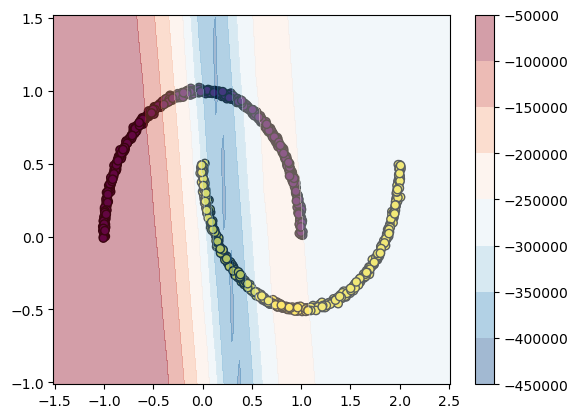

<Figure size 640x480 with 0 Axes>

In [62]:
xx = xy_grid[:, 0].reshape(N, N)
yy = xy_grid[:, 1].reshape(N, N)
Z = Scalar.reshape(N, N)
plt.scatter(activations_np[0][:, 0], activations_np[0][:, 1], c=dataset.y, edgecolors='k')
contour = plt.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu_r")
plt.colorbar(contour)
plt.show()
plt.savefig("figures/underfit_scalar_curvature.png")

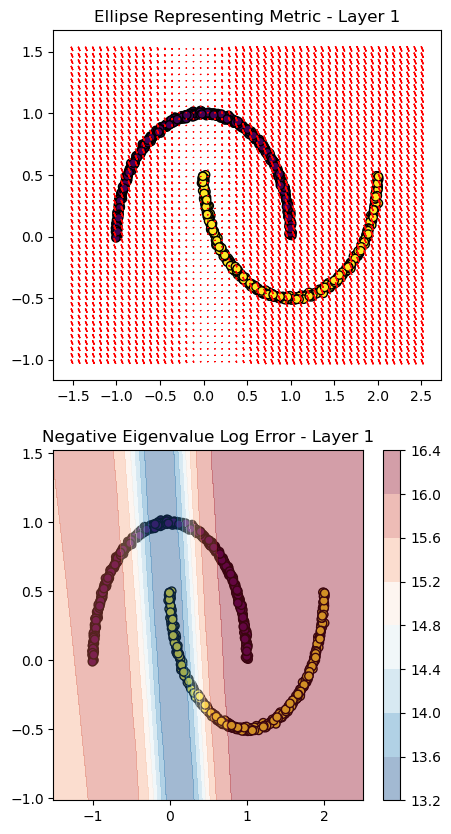

In [65]:
layer = 1
Ricci_tensor = torch.from_numpy(Ricci).float()
eigenvalues, eigenvectors = torch.linalg.eigh(Ricci_tensor)
eigenvalues = eigenvalues.detach().numpy()
errors = np.log(1-eigenvalues[:,0] * (eigenvalues[:, 0] < 0))
eigenvalues = eigenvalues * (eigenvalues > 0)
eigenvalues = np.sqrt(eigenvalues)
eigenvectors = eigenvectors.detach().numpy()

fig, ax = plt.subplots(2, 1, figsize=(5, 10))

ax[0].scatter(activations_np[0][:, 0], activations_np[0][:, 1], c=dataset.y, edgecolors='k')
ax[0].set_title(f'Ellipse Representing Metric - Layer {layer}')
max_x, max_y = np.max(xy_grid[:, 0]), np.max(xy_grid[:, 1])
min_x, min_y = np.min(xy_grid[:, 0]), np.min(xy_grid[:, 1])
max_g_0, max_g_1 = np.max(eigenvalues[:, 0]), np.max(eigenvalues[:, 1])
eigenvalues[:, 0] = eigenvalues[:, 0]/(max_g_0 + 1e-5)
eigenvalues[:, 1] = eigenvalues[:, 1]/(max_g_1 + 1e-5)
eigenvalues = (eigenvalues * np.array([max_x - min_x, max_y - min_y]) )/ N
for indx, (point, eigenvals, eigenvecs) in enumerate(zip(xy_grid, eigenvalues, eigenvectors)):
    width, height = eigenvals
    angle = np.degrees(np.arctan2(eigenvecs[0, 1], eigenvecs[0,0]))
    ellipse = Ellipse(xy=point, width=width, height=height, 
                      angle=angle, edgecolor='r', facecolor='none')
    ax[0].add_patch(ellipse)
xx = xy_grid[:, 0].reshape(N, N)
yy = xy_grid[:, 1].reshape(N, N)
Z = errors.reshape(N, N)
ax[1].scatter(activations_np[0][:, 0], activations_np[0][:, 1], c=dataset.y, edgecolors='k')
ax[1].set_title(f'Negative Eigenvalue Log Error - Layer {layer}')
contour = ax[1].contourf(xx, yy, Z, alpha=0.4, cmap="RdBu_r")
plt.colorbar(contour)
plt.savefig("figures/underfit_ricci.png")